In [33]:
import random
import tensorflow as tf
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn import model_selection

In [2]:
def createLSTMLayers(n_layers, n_cells, dropout):
    cell_list = []
    
    for layer in range(n_layers):
        cell = tf.contrib.rnn.LayerNormBasicLSTMCell(n_cells, activation=tf.nn.relu, layer_norm=False)
        
        cell_list.append(cell)
        
    return cell_list

In [3]:
def padSeq(seqs, pad_length, right_pad=True):
    
    '''
    padSeq
    
    Pad sequences to be equal length.
    
    seqs: sequences to be padded
    pad_length: length to pad sequences
    left_pad: Pad at the end of the sequences, or reverse pad from front
    '''
    
    padded_seqs = np.zeros((len(seqs), pad_length))
    
    for idx_row, row in enumerate(seqs):
        for idx_col, col in enumerate(row):
            if right_pad:
                padded_seqs[idx_row, idx_col] = seqs[idx_row][idx_col]
            else:
                padded_seqs[idx_row, pad_length-idx_col-1] = seqs[idx_row][len(row)-idx_col-1]
    return padded_seqs

def generatePseudoSequences(seq_length, low, high, n_seqs, variable_length=False):
    
    '''
    generatePseudoSequences
    
    seq_length: Length of sequence to generate
    low: lower bound of values
    high: upper bound of values
    n_seqs: number of sequences to generate
    variable_length: Create sequence of variable length    
    '''
    
    #Generate random sequences
    random_seqs = []
    for seq in range(n_seqs):
        if variable_length: current_length = random.randint(1, seq_length)
        else: current_length = seq_length
        current_seq = [random.randint(low, high) for _ in range(current_length)]
        
        random_seqs.append(current_seq)
        
    return random_seqs

In [4]:
tf.reset_default_graph()

In [5]:
#Network parameters
encoder_layers = 1
encoder_cells = 5
encoder_dropout = 1

decoder_layers = 1
decoder_cells = 5
decoder_dropout = 1

seq_length = 5
n_features = 1

latent_dimensions = 2

#Training Parameters
lr = 0.001
batch_size = 32

In [6]:
inputs = tf.placeholder(name='input', shape=[None, seq_length, n_features], dtype=tf.float32)

In [8]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    q = sess.run([encoder_final_state], {inputs:[[[2.], [2.],[2.], [2.], [2.]]]})

In [7]:
#encoder
with tf.variable_scope('encoder', reuse=False):
    
    encoder_cell_fw = tf.contrib.rnn.MultiRNNCell(createLSTMLayers(encoder_layers, encoder_cells, encoder_dropout))
    encoder_cell_bw = tf.contrib.rnn.MultiRNNCell(createLSTMLayers(encoder_layers, encoder_cells, encoder_dropout))
    
    (encoder_fw_outputs, encoder_bw_outputs), encoder_state_outputs = tf.nn.bidirectional_dynamic_rnn(
                                        encoder_cell_fw,
                                        encoder_cell_bw, 
                                        inputs=inputs,
                                        dtype=tf.float32, time_major=False, swap_memory=True)
    
    encoder_final_state = tf.concat([state_tuple[0].h for state_tuple in encoder_state_outputs], axis=1)

In [11]:
latent_vector_in = tf.contrib.layers.fully_connected(encoder_final_state, latent_dimensions, activation_fn=tf.nn.relu)

In [12]:
latent_vector_out = tf.contrib.layers.fully_connected(latent_vector_in, decoder_cells, activation_fn=tf.nn.relu)

In [13]:
decoder_inputs = tf.zeros([tf.shape(inputs)[0], seq_length, n_features])

In [14]:
decoder_initial_state = tuple([tf.nn.rnn_cell.LSTMStateTuple(c=latent_vector_out, h=latent_vector_out) for i in 
                              range(decoder_layers)])

In [15]:
#decoder

with tf.variable_scope('decoder', reuse=False):
    
    decoder_cell_fw = tf.contrib.rnn.MultiRNNCell(createLSTMLayers(decoder_layers, decoder_cells, decoder_dropout))
    decoder_cell_bw = tf.contrib.rnn.MultiRNNCell(createLSTMLayers(decoder_layers, decoder_cells, decoder_dropout))
    
    (decoder_fw_outputs, decoder_bw_outputs), decoder_state_outputs = tf.nn.bidirectional_dynamic_rnn(
                                        decoder_cell_fw,
                                        decoder_cell_bw, 
                                        inputs=decoder_inputs,
                                        initial_state_fw=decoder_initial_state,
                                        initial_state_bw=decoder_initial_state,
                                        dtype=tf.float32, time_major=False, swap_memory=True)
    
    decoder_outputs = tf.concat([decoder_fw_outputs, decoder_bw_outputs], axis=2)

In [16]:
output_layer = tf.contrib.layers.fully_connected(decoder_outputs, n_features, activation_fn=tf.nn.relu)

In [17]:
loss = tf.reduce_sum(tf.square(inputs-output_layer))

In [18]:
optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)

In [19]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    q = sess.run([output_layer], {inputs:[[[2.], [2.], [2.], [2.], [2.]]]})

In [21]:
df_seqs = pd.DataFrame(padSeq(generatePseudoSequences(5, 1, 10, 10000, variable_length=True), 5))

In [22]:
df_train, df_test = model_selection.train_test_split(df_seqs, test_size=0.2)

In [23]:
#training

n_epochs = 10

n_batches = df_train.shape[0]//batch_size

In [24]:
print (n_epochs, n_batches)

10 250


In [37]:
batch

array([[[  1.],
        [  7.],
        [  6.],
        [  8.],
        [  0.]],

       [[  8.],
        [  5.],
        [  9.],
        [  1.],
        [  0.]],

       [[ 10.],
        [  0.],
        [  0.],
        [  0.],
        [  0.]],

       [[  2.],
        [  3.],
        [  1.],
        [  0.],
        [  0.]],

       [[  8.],
        [  2.],
        [ 10.],
        [  0.],
        [  0.]],

       [[  8.],
        [  4.],
        [  4.],
        [ 10.],
        [  0.]],

       [[  8.],
        [  3.],
        [  0.],
        [  0.],
        [  0.]],

       [[  9.],
        [  0.],
        [  0.],
        [  0.],
        [  0.]],

       [[  3.],
        [  0.],
        [  0.],
        [  0.],
        [  0.]],

       [[  8.],
        [  9.],
        [  7.],
        [  7.],
        [  0.]],

       [[  9.],
        [  9.],
        [  5.],
        [  7.],
        [  0.]],

       [[ 10.],
        [  8.],
        [ 10.],
        [  9.],
        [  0.]],

       [[  5.],


In [31]:
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    
    print ('Begin training')
    
    for c_epoch in range(n_epochs):
        df_epoch_samples = df_train.sample(frac=1)
        for c_batch in range(n_batches): 
            batch = df_epoch_samples[c_batch*batch_size:(c_batch+1)*batch_size].values
            batch = batch.reshape(len(batch), seq_length, 1)
            _, c_loss = sess.run([optimizer, loss], {inputs:batch})
            
            if c_batch%100==0:
                print ('epoch:%d, batch:%d, loss:%.3g' % (c_epoch, c_batch, c_loss))
    
    latent_vectors = sess.run(latent_vector_in, {inputs:df_train.values.reshape(df_train.shape[0], seq_length, 1)})


Begin training
epoch:0, batch:0, loss:4.7e+03
epoch:0, batch:100, loss:1.12e+03
epoch:0, batch:200, loss:1.08e+03
epoch:1, batch:0, loss:947
epoch:1, batch:100, loss:753
epoch:1, batch:200, loss:821
epoch:2, batch:0, loss:767
epoch:2, batch:100, loss:666
epoch:2, batch:200, loss:486
epoch:3, batch:0, loss:587
epoch:3, batch:100, loss:593
epoch:3, batch:200, loss:746
epoch:4, batch:0, loss:603
epoch:4, batch:100, loss:687
epoch:4, batch:200, loss:645
epoch:5, batch:0, loss:724
epoch:5, batch:100, loss:463
epoch:5, batch:200, loss:691
epoch:6, batch:0, loss:542
epoch:6, batch:100, loss:574
epoch:6, batch:200, loss:576
epoch:7, batch:0, loss:473
epoch:7, batch:100, loss:524
epoch:7, batch:200, loss:557
epoch:8, batch:0, loss:676
epoch:8, batch:100, loss:536
epoch:8, batch:200, loss:556
epoch:9, batch:0, loss:524
epoch:9, batch:100, loss:532
epoch:9, batch:200, loss:621


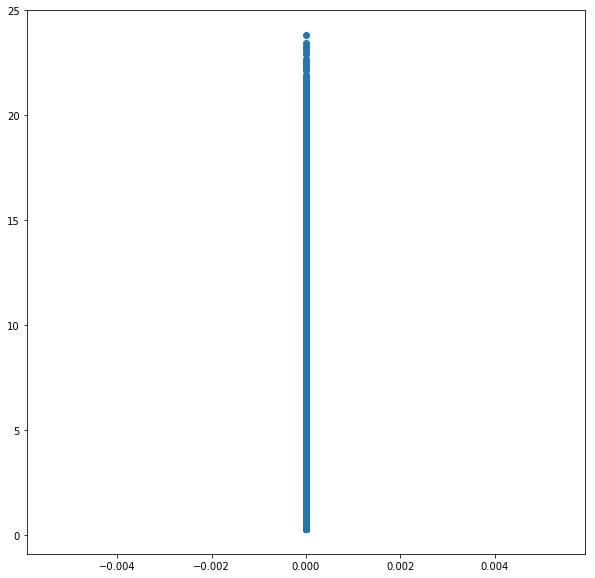

In [36]:
#Analysis

plt.figure(figsize=(10, 10))
plt.scatter(latent_vectors[:,0], latent_vectors[:,1])
plt.show()